In [1]:
#Loading Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')
from sklearn import metrics
import seaborn as sns
%matplotlib inline

In [2]:
#Gathering Data
logs = pd.read_csv("C:/Users/Bre/Desktop/netflow_day-02.csv", sep=",", index_col=False, nrows = 5000)

In [3]:
logs.head()

,time,duration,srcDevice,dstDevice,protocol,srcPort,dstPort,srcPackets,dstPackets,srcBytes,dstBytes
0,118781,5580,Comp364445,Comp547245,17,Port05507,Port46272,0,755065,0,1042329018
1,118783,6976,Comp450942,Comp829338,6,Port03137,445,1665,1108,300810,250408
2,118785,14178,IP564116,Comp141988,17,5060,5060,1866,0,1477041,0
3,118785,28147,IP564116,Comp141988,17,5060,5060,3326,0,2656305,0
4,118785,48507,IP564116,Comp141988,17,5060,5060,5423,0,4388449,0


In [4]:
#Selecting String Value Fields To Be Used In Modelling
X = logs[['srcBytes', 'srcPackets', 'dstBytes', 'dstPackets']]

In [5]:
#Loading Min Max Scaling and Creating New Data Frame
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_normalized = pd.DataFrame(scaler.fit_transform(X))        #We Normalized the data so that we can accurately compare them

In [6]:
#Assining Column Names. We Normalize these columns to have a common scalar value since Packet No. & Byte Size are different
X_normalized.columns = ['srcBytes', 'srcPackets', 'dstBytes', 'dstPackets']

# KMeans Implementation

In [7]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)          #n_clusters = 2 Explicitly states how many clusters we're working with (i.e. 2)
kmeans.fit(X_normalized)
y_kmeans = kmeans.predict(X_normalized)

In [8]:
#Assigning cluster centers
centers = kmeans.cluster_centers_
print('Cluster centers of columns:\n')
print(pd.DataFrame(centers,columns= ['srcBytes', 'srcPackets', 'dstBytes', 'dstPackets']))

Cluster centers of columns:

   srcBytes  srcPackets  dstBytes  dstPackets
0  0.001155    0.000646  0.001059    0.000199
1  0.999874    0.999883  0.999962    0.999991


# Elbow Method

In [9]:
from sklearn import metrics
from scipy.spatial.distance import cdist

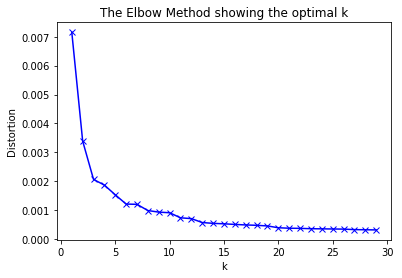

In [10]:
distortions = []
K = range(1,30)           #States how many points we want plotted on our Elbow Graph
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X_normalized)
    kmeanModel.fit(X_normalized)
    distortions.append(sum(np.min(cdist(X_normalized, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X_normalized.shape[0])
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# Mean-Shift

In [11]:
#Mean-Shift Clustering
from sklearn.cluster import MeanShift, estimate_bandwidth

ms = MeanShift(bin_seeding=True)
ms.fit(X_normalized)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 48


# Printing The Labels

In [12]:
labels = kmeans.labels_
print(labels)

[0 0 0 ... 0 0 0]


# Duplicate Data Logs Testing

In [31]:
xLogs = logs               #xLogs is a copy of the original data set

xLogs['clusters'] = labels #Adding the corresponding labels as a column to the data set
#xLogs.drop('[column name]', axis = 1, inplace=True) <----- Used to completely delete a column. axis=1 means a column

#X2 is the PCA-subset of the data set
X2 = xLogs[['srcPackets','dstPackets','srcBytes','dstBytes']]

#X3 is the same as X2 but with the cluster column
X3_clusters = xLogs[['srcPackets','dstPackets','srcBytes','dstBytes', 'clusters']]

In [14]:
xLogs.head()

,time,duration,srcDevice,dstDevice,protocol,srcPort,dstPort,srcPackets,dstPackets,srcBytes,dstBytes,clusters
0,118781,5580,Comp364445,Comp547245,17,Port05507,Port46272,0,755065,0,1042329018,0
1,118783,6976,Comp450942,Comp829338,6,Port03137,445,1665,1108,300810,250408,0
2,118785,14178,IP564116,Comp141988,17,5060,5060,1866,0,1477041,0,0
3,118785,28147,IP564116,Comp141988,17,5060,5060,3326,0,2656305,0,0
4,118785,48507,IP564116,Comp141988,17,5060,5060,5423,0,4388449,0,0


In [15]:
#Printing a particular index
xLogs.ix[312]

time               119169
duration            46850
srcDevice      Comp004479
dstDevice      Comp274690
protocol                6
srcPort         Port17617
dstPort              2049
srcPackets      188012056
dstPackets     1106026322
srcBytes      18243509496
dstBytes      45576786992
clusters                1
Name: 312, dtype: object

# Cluster ID 1

In [16]:
#Used to find the indexes of those rows where the Cluster equals 1
np.where(xLogs["clusters"] == 1)

(array([310, 311, 312, 313, 314, 315], dtype=int64),)

In [17]:
#Used to select the entire element/row where clusters = 1
cluster1_rows = list(np.where(xLogs["clusters"] == 1)[0])
xLogs.iloc[cluster1_rows]
#len(select_rows)                                       #Returns the number of rows that matched our prior condition

,time,duration,srcDevice,dstDevice,protocol,srcPort,dstPort,srcPackets,dstPackets,srcBytes,dstBytes,clusters
310,119169,14275,Comp004479,Comp274690,6,Port17617,2049,84515677,588887960,8197543524,22300992620,1
311,119169,27231,Comp004479,Comp274690,6,Port17617,2049,187996382,1106018577,18241852484,45575479772,1
312,119169,46850,Comp004479,Comp274690,6,Port17617,2049,188012056,1106026322,18243509496,45576786992,1
313,119169,65450,Comp004479,Comp274690,6,Port17617,2049,188026938,1106033761,18245057412,45578036816,1
314,119169,82190,Comp004479,Comp274690,6,Port17617,2049,188040322,1106040453,18246449348,45579161072,1
315,119169,87872,Comp004479,Comp274690,6,Port17617,2049,188046450,1106042771,18247093588,45579557920,1


# Cluster ID 2 (if cluster size increased)

In [18]:
#Used to find the indexes of those rows where the Cluster equals 2
#np.where(xLogs["clusters"] == 2)

(array([], dtype=int64),)

In [19]:
#Used to select the entire element/row where clusters = 2
#cluster2_rows = list(np.where(xLogs["clusters"] == 2)[0])
#xLogs.iloc[cluster2_rows]

,time,duration,srcDevice,dstDevice,protocol,srcPort,dstPort,srcPackets,dstPackets,srcBytes,dstBytes,clusters


# Scatter Plot

In [32]:
#Loading Min Max Scaling and Creating New Data Frame
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X2_normalized = pd.DataFrame(scaler.fit_transform(X2))        #We Normalized the data so that we can accurately compare them
X3_clusters_normalized = pd.DataFrame(scaler.fit_transform(X3_clusters))

In [33]:
#Assining Column Names. We Normalize these columns to have a common scalar value since Packet No. & Byte Size are different
X2_normalized.columns = ['srcBytes', 'srcPackets', 'dstBytes', 'dstPackets']
X3_clusters_normalized.columns = ['srcBytes', 'srcPackets', 'dstBytes', 'dstPackets', 'clusters']

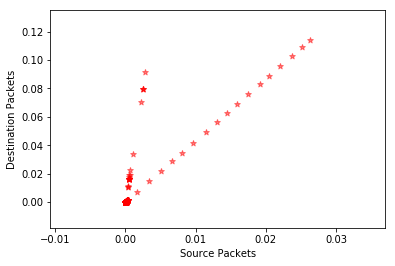

In [17]:
import matplotlib.pyplot as plt

#Selecting the first n rows. Data changes at 311 where cluster ID 1 emerges and shrinks the graph scale
x = X2_normalized['srcPackets'].head(310)
y = X2_normalized['dstPackets'].head(310)

plt.scatter(x, y, alpha=0.5, c="red", marker='*')
plt.xlabel("Source Packets")
plt.ylabel("Destination Packets")
plt.show()

# Elliptic Envelope

In [84]:
#Implementing Algorithm
#Using The Elliptic Envelope would work optimal since our data appears to be linear
from sklearn.covariance import EllipticEnvelope
elliptic = EllipticEnvelope()
elliptic.fit(X2_normalized)
#elliptic.fit(X3_clusters_normalized)

EllipticEnvelope(assume_centered=False, contamination=0.1, random_state=None,
         store_precision=True, support_fraction=None)

In [68]:
#Predicting Anomaly Class and Anomaly Score
Anomaly_Class = elliptic.predict(X2_normalized)
Anomaly_Score = elliptic.decision_function(X2_normalized)

In [69]:
#Creating New Columns Based on Anomaly Detection
X2['Anomaly_Class'] = Anomaly_Class
X2['Anomaly_Score'] = Anomaly_Score

In [21]:
#Viewing Class Counts
#-1 is anomaly, 1 is normal
X2.groupby('Anomaly_Class')[['Anomaly_Score']].count()

,Anomaly_Score
Anomaly_Class,
-1,500
1,4500


In [26]:
#Used to find the indexes of those rows where the Anomaly Class equals -1
np.where(X2["Anomaly_Class"] == -1)

(array([   0,   17,   18,   19,   20,   21,   34,   35,   36,   60,   62,
          64,   66,   67,   68,   69,   70,   71,   72,   73,   74,   75,
          76,   77,   78,   79,   92,   93,   94,   95,   96,   97,   98,
          99,  162,  163,  164,  165,  166,  167,  168,  175,  176,  177,
         178,  179,  180,  181,  183,  184,  186,  187,  188,  190,  191,
         192,  193,  194,  195,  196,  197,  198,  202,  203,  204,  205,
         206,  207,  208,  209,  210,  211,  212,  213,  214,  215,  216,
         217,  218,  219,  220,  221,  222,  223,  224,  225,  226,  227,
         228,  229,  230,  231,  232,  233,  234,  235,  236,  237,  238,
         239,  240,  241,  259,  261,  262,  265,  267,  268,  278,  279,
         290,  291,  292,  293,  294,  295,  296,  298,  299,  300,  301,
         302,  303,  304,  305,  306,  307,  310,  311,  312,  313,  314,
         315,  327,  328,  329,  330,  331,  353,  354,  355,  356,  357,
         358,  359,  393,  394,  395, 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000074A8779240>,
      dtype=object)

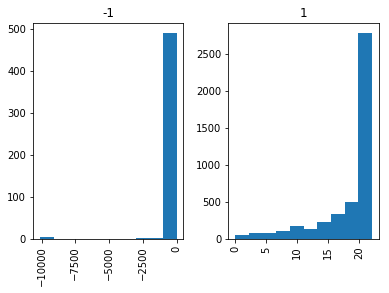

In [27]:
#Histogram of Anomaly Scores By Anomaly Class
X2['Anomaly_Score'].hist(by=X2['Anomaly_Class'])

In [56]:
#Implementing Algorithm With Different Parameters where we increased the contamination parameters
from sklearn.covariance import EllipticEnvelope
elliptic = EllipticEnvelope(contamination=0.2)
elliptic.fit(X2_normalized)

EllipticEnvelope(assume_centered=False, contamination=0.2, random_state=None,
         store_precision=True, support_fraction=None)

In [57]:
#Predicting Anomaly Class and Anomaly Score
Anomaly_Class = elliptic.predict(X2_normalized)
Anomaly_Score = elliptic.decision_function(X2_normalized)

In [58]:
#Creating New Columns Based on Anomaly Detection
X2['Anomaly_Class_Contamination'] = Anomaly_Class
X2['Anomaly_Score_Contamination'] = Anomaly_Score

In [59]:
X2.groupby('Anomaly_Class_Contamination')[['Anomaly_Score_Contamination']].count()

,Anomaly_Score_Contamination
Anomaly_Class_Contamination,
-1,1000
1,4000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000074A8B985C0>,
      dtype=object)

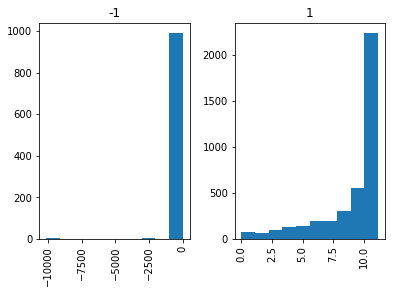

In [60]:
X2['Anomaly_Score_Contamination'].hist(by=X2['Anomaly_Class_Contamination'])

In [74]:
X2.head()

,srcPackets,dstPackets,srcBytes,dstBytes,Anomaly_Class_Contamination,Anomaly_Score_Contamination,Anomaly_Class,Anomaly_Score
0,0,755065,0,1042329018,-1,-330.553060,-1,-319.691927
1,1665,1108,300810,250408,1,10.500356,1,21.361489
2,1866,0,1477041,0,1,7.588436,1,18.449568
3,3326,0,2656305,0,1,5.603671,1,16.464803
4,5423,0,4388449,0,1,3.168006,1,14.029138


In [83]:
#Top 5 Anomaly Records
X2[['Anomaly_Score_Contamination','Anomaly_Score']].head().sort_values(['Anomaly_Score_Contamination'], ascending=[1])

,Anomaly_Score_Contamination,Anomaly_Score
0,-330.553060,-319.691927
4,3.168006,14.029138
3,5.603671,16.464803
2,7.588436,18.449568
1,10.500356,21.361489
